# Transformers for Machine Translation

**Author**: Chris Oswald

**Course**: CS676/ECE689 Advanced Topics in Deep Learning (Spring 2024)

## Setup

In [ ]:
!pip install datasets
!pip install accelerate -U
!pip install transformers -U

In [ ]:
# Load packages
import json
import os
import math
import time
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create directories
from google.colab import drive
drive.mount('/content/drive')

models_dir = "/content/drive/MyDrive/Colab Notebooks/Models"
os.makedirs(models_dir, exist_ok=True)

data_dir = "/content/drive/MyDrive/Colab Notebooks/Data"
os.makedirs(data_dir, exist_ok=True)

## Question 3: Transformer for translation

Here, we implement transformers for neural machine translation (NMT), such as turning "Hello world" to "Salut le monde". You are going to follow the following steps:
1. Load and prepare the data. We provide "en-ft.txt". Each line of this file contains an English phrase, the equivalent French phrase, and an attribution identifying where the translation came from. The en-fr.txt used in problem 3 can also be found at: https://github.com/jeffprosise/Applied-Machine-Learning/tree/main/Chapter%2013/Data
2. Build and train a model. Implement a transformer from scratch in Pytorch. We will provide you with an existing implementation in Keras. You might also find https://github.com/gordicaleksa/pytorch-original-transformer useful.

For deliverables, plot your training and validation accuracy. The x-axis should be epoch, the y-axis should be your translation accuracy.

For reference, the provided code given at https://github.com/jeffprosise/Applied-Machine-Learning/blob/main/Chapter%2013/Neural%20Machine%20Translation%20(Transformer).ipynb achieves 85% accuracy after 14 epochs. You do not have to achieve the same performance to get full marks, just show understanding and functional codes.

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Data'
os.makedirs(data_dir, exist_ok=True)

In [ ]:
"""Clean the text by removing punctuation symbols and numbers, converting
characters to lowercase, and replacing Unicode characters with their ASCII
equivalents. For the French samples, insert [start] and [end] tokens at the
 beginning and end of each phrase"""
import pandas as pd
import re
from unicodedata import normalize

df = pd.read_csv(
    os.path.join(data_dir, 'en-fr.txt'),
    names=['en', 'fr', 'attr'],
    usecols=['en', 'fr'],
    sep='\t'
)
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)
df.head()

def clean_text(text):
    text = normalize('NFD', text.lower())
    text = re.sub('[^A-Za-z ]+', '', text)
    return text

def clean_and_prepare_text(text):
    text = '[start] ' + clean_text(text) + ' [end]'
    return text

df['en'] = df['en'].apply(lambda row: clean_text(row))
df['fr'] = df['fr'].apply(lambda row: clean_and_prepare_text(row))
df.head()

,en,fr
0,youre very clever,[start] vous etes fort ingenieuse [end]
1,are there kids,[start] y atil des enfants [end]
2,come in,[start] entrez [end]
3,wheres boston,[start] ou est boston [end]
4,you see what i mean,[start] vous voyez ce que je veux dire [end]


In [ ]:
"""The next step is to scan the phrases and determine the maximum length of the
English phrases and then of the French phrases. These lengths will determine
the lengths of the sequences input to and output from the model"""
en = df['en']
fr = df['fr']

en_max_len = max(len(line.split()) for line in en)
fr_max_len = max(len(line.split()) for line in fr)
sequence_len = max(en_max_len, fr_max_len)

print(f'Max phrase length (English): {en_max_len}')
print(f'Max phrase length (French): {fr_max_len}')
print(f'Sequence length: {sequence_len}')

Max phrase length (English): 7
Max phrase length (French): 16
Sequence length: 16


In [ ]:
"""Now fit one Tokenizer to the English phrases and another Tokenizer to their
French equivalents, and generate padded sequences for all the phrases"""
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(en)
en_sequences = en_tokenizer.texts_to_sequences(en)
en_x = pad_sequences(en_sequences, maxlen=sequence_len, padding='post')

fr_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n')
fr_tokenizer.fit_on_texts(fr)
fr_sequences = fr_tokenizer.texts_to_sequences(fr)
fr_y = pad_sequences(fr_sequences, maxlen=sequence_len + 1, padding='post')

In [ ]:
"""Compute the vocabulary sizes from the Tokenizer instances"""
en_vocab_size = len(en_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

print(f'Vocabulary size (English): {en_vocab_size}')
print(f'Vocabulary size (French): {fr_vocab_size}')

Vocabulary size (English): 6033
Vocabulary size (French): 12197


In [ ]:
"""Finally, create the features and the labels the model will be trained with.
The features are the padded English sequences and the padded French sequences
minus the [end] tokens. The labels are the padded French sequences minus the
[start] tokens. Package the features in a dictionary so they can be input to a
model that accepts multiple inputs."""
inputs = { 'encoder_input': en_x, 'decoder_input': fr_y[:, :-1] }
outputs = fr_y[:, 1:]

Now, define and train the transformer in Pytorch. We provide here some example code in Keras, **but note that you have to write it in Pytorch**.

### Example Code (Keras)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from keras_nlp.layers import TokenAndPositionEmbedding, TransformerEncoder
from keras_nlp.layers import TransformerDecoder
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

np.random.seed(42)
tf.random.set_seed(42)

num_heads = 8
embed_dim = 256

encoder_input = Input(shape=(None,), dtype='int64', name='encoder_input')
x = TokenAndPositionEmbedding(en_vocab_size, sequence_len, embed_dim)(encoder_input)
encoder_output = TransformerEncoder(embed_dim, num_heads)(x)
encoded_seq_input = Input(shape=(None, embed_dim))

decoder_input = Input(shape=(None,), dtype='int64', name='decoder_input')
x = TokenAndPositionEmbedding(fr_vocab_size, sequence_len, embed_dim, mask_zero=True)(decoder_input)
x = TransformerDecoder(embed_dim, num_heads)(x, encoded_seq_input)
x = Dropout(0.4)(x)

decoder_output = Dense(fr_vocab_size, activation='softmax')(x)
decoder = Model([decoder_input, encoded_seq_input], decoder_output)
decoder_output = decoder([decoder_input, encoder_output])

model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary(line_length=120)

callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
hist = model.fit(inputs, outputs, epochs=50, validation_split=0.2, callbacks=[callback])

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

## Pytorch Implementation

In [ ]:
class PosEncoder(nn.Module):
    """
    Positional encoder class.
    Based on based on https://pytorch.org/tutorials/beginner/transformer_tutorial.html.
    """

    def __init__(
        self,
        embed_dim: int,
        sequence_len: int,
        dropout_share: float = 0.1,
    ):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_share)
        pe = self.create_position_encoding(embed_dim, sequence_len)
        self.register_buffer('pos_encoder', pe)

    def create_position_encoding(self, embed_dim: int, sequence_len: int):
        """Create positional encoding for each token in sequence."""
        position = torch.arange(sequence_len).unsqueeze(1)
        factor = (
            torch.exp(torch.arange(0, embed_dim, 2)
            * (-math.log(10000.0) / embed_dim))
        )
        pos_encoder = torch.zeros(1, sequence_len, embed_dim)
        pos_encoder[0, :, 0::2] = torch.sin(position * factor)
        pos_encoder[0, :, 1::2] = torch.cos(position * factor)
        return pos_encoder

    def forward(self, x):
        """Add positional encoder value to tensor and pass through dropout layer."""
        return self.dropout(x + self.pos_encoder[:, :x.size(1)])


class Encoder(nn.Module):
    """Encoder class.
    Based on https://pytorch.org/tutorials/beginner/transformer_tutorial.html.
    """
    def __init__(
        self,
        embed_dim: int,
        n_heads: int,
        n_layers: int,
    ):
        super().__init__()
        encoder_layers = nn.TransformerEncoderLayer(embed_dim, n_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layers, n_layers)

    def forward(self, x):
        return self.encoder(x)


class Decoder(nn.Module):
    """Decoder class.
    Based on https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoderLayer.html
    """
    def __init__(
        self,
        embed_dim: int,
        n_heads: int,
        n_layers: int,
    ):
        super().__init__()
        decoder_layers = nn.TransformerDecoderLayer(embed_dim, n_heads, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layers, n_layers)

    def forward(self, x, memory):
        # Create target mask (matrix with upper triangular = -inf, lower = 0)
        mask = nn.Transformer.generate_square_subsequent_mask(x.shape[1]).to(x.device)
        return self.decoder(x, memory, tgt_mask=mask)


class Transformer(nn.Module):
    """Transformer implementation in PyTorch.

    Based on https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    and https://github.com/gordicaleksa/pytorch-original-transformer.

    """

    def __init__(
        self,
        n_layers: int,
        src_vocab_size: int,
        tgt_vocab_size: int,
        embed_dim: int,
        n_heads: int,
        sequence_len: int,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.src_embedding = nn.Embedding(src_vocab_size, embed_dim)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, embed_dim)
        self.pos_encoder = PosEncoder(embed_dim, sequence_len)
        self.transformer_encoder = Encoder(embed_dim, n_heads, n_layers)
        self.transformer_decoder = Decoder(embed_dim, n_heads, n_layers)
        self.linear = nn.Linear(embed_dim, tgt_vocab_size)

    def forward(self, src, target):
        src = self.pos_encoder(self.src_embedding(src) * math.sqrt(self.embed_dim))
        target = self.pos_encoder(self.tgt_embedding(target) * math.sqrt(self.embed_dim))
        input_encoded = self.transformer_encoder(src)
        output = self.transformer_decoder(target, input_encoded)
        return self.linear(output)


class TranslationDataset(torch.utils.data.Dataset):
    """Merge source and target data."""

    def __init__(self, src, target):
        self.src = src
        self.target = target

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        return self.src[idx], self.target[idx]


In [ ]:
# Create model
np.random.seed(999)
torch.manual_seed(999)

n_layers = 2
embed_dim = 256
n_heads = 8

model = Transformer(
    n_layers=n_layers,
    src_vocab_size=en_vocab_size,
    tgt_vocab_size=fr_vocab_size,
    embed_dim=embed_dim,
    n_heads=n_heads,
    sequence_len=sequence_len,
)
model.to(device)

loss_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Create train/validation split
en_fr_data = TranslationDataset(en_x, fr_y)
valid_share = 0.2
batch_size = 128

total_obs = len(en_fr_data)
valid_obs = int(total_obs * valid_share)
train_data, valid_data = torch.utils.data.random_split(
    en_fr_data,
    lengths=[total_obs - valid_obs, valid_obs],
    generator=torch.Generator().manual_seed(999),
)

train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

In [ ]:
# Model training/validation
metrics = {}
lowest_avg_loss = None

n_epochs = 4

for epoch in range(n_epochs):

    # Train model
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_idx, (src, target) in enumerate(train_dl):
        src = src.to(device)
        target = target[:, 1:].to(device) # remove <start> tokens

        optimizer.zero_grad()
        output = model(src, target)

        # Reshape output and target for cross entropy loss
        reshaped_output = output.view(-1, output.size(-1))
        reshaped_target = target.reshape(-1).long()

        loss = loss_criterion(reshaped_output, reshaped_target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Compute accuracy for visualization
        _, train_preds = torch.max(reshaped_output, 1)
        train_correct += (train_preds == reshaped_target).sum().item()
        train_total += reshaped_target.size(0)

    train_avg_loss = train_loss / len(train_dl)
    train_acc = train_correct / train_total
    print(f"Epoch: {epoch}, Train Loss: {train_avg_loss:.4f}, "+
          f"Train Accuracy: {train_acc:.4f}")

    # Evaluate on validation set after each epoch
    model.eval()
    validation_loss = 0.0
    validation_correct = 0
    validation_total = 0

    with torch.no_grad():
        for batch_idx, (src, target) in enumerate(valid_dl):
            src = src.to(device)
            target = target[:, 1:].to(device)

            output = model(src, target)

            # Reshape output and target for cross entropy loss
            reshaped_output = output.view(-1, output.size(-1))
            reshaped_target = target.reshape(-1).long()

            loss = loss_criterion(reshaped_output, reshaped_target)
            validation_loss += loss.item()

            # Compute accuracy for visualization
            _, validation_idxs = torch.max(reshaped_output, 1)
            validation_correct += (validation_idxs == reshaped_target).sum().item()
            validation_total += reshaped_target.size(0)

    validation_avg_loss = validation_loss / len(valid_dl)
    validation_acc = validation_correct / validation_total
    print(f"Epoch: {epoch}, Validation Loss: {validation_avg_loss:.4f}, " +
          f"Validation Accuracy: {validation_acc:.4f}")

    # Save model if improving
    if (lowest_avg_loss is None) or (validation_avg_loss < lowest_avg_loss):
        lowest_avg_loss = validation_avg_loss
        torch.save(
            model.state_dict(),
            os.path.join(models_dir, f'TransformerModel_epoch{epoch}.pt')
        )
        print(f'Saved model for epoch {epoch}')

    # Store metrics for plotting
    metrics[epoch] = {
        "train_loss": train_avg_loss,
        "train_acc": train_acc,
        "validation_loss": validation_avg_loss,
        "validation_acc": validation_acc
    }

# Save metrics
metrics_path = os.path.join(data_dir, 'TransformerModel_metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(metrics, f)

Epoch: 0, Train Loss: 0.1092, Train Accuracy: 0.9903
Epoch: 0, Validation Loss: 0.1071, Validation Accuracy: 0.9913
Saved model for epoch 0
Epoch: 1, Train Loss: 0.0397, Train Accuracy: 0.9981
Epoch: 1, Validation Loss: 0.0860, Validation Accuracy: 0.9921
Saved model for epoch 1
Epoch: 2, Train Loss: 0.0098, Train Accuracy: 1.0000
Epoch: 2, Validation Loss: 0.0837, Validation Accuracy: 0.9921
Saved model for epoch 2
Epoch: 3, Train Loss: 0.0012, Train Accuracy: 1.0000
Epoch: 3, Validation Loss: 0.0835, Validation Accuracy: 0.9921
Saved model for epoch 3


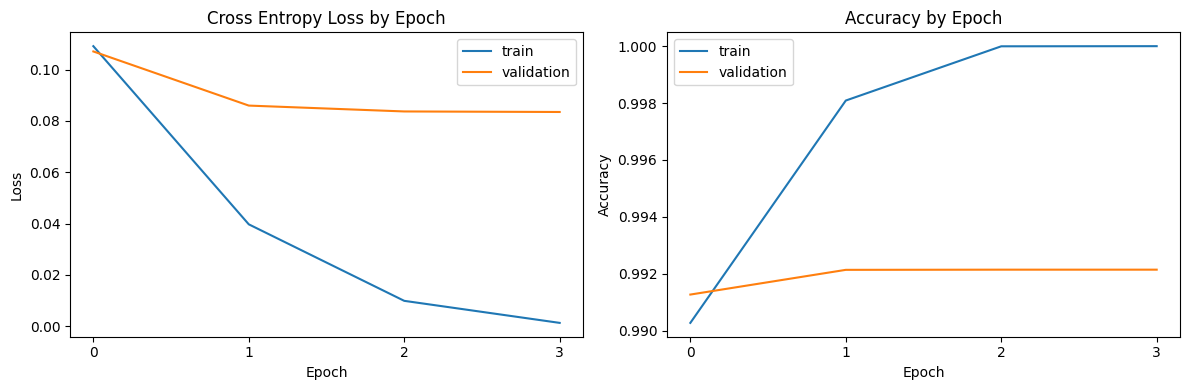

In [ ]:
# Plot metrics
df = pd.DataFrame(metrics).T
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(df['train_loss'], label='train')
ax[0].plot(df['validation_loss'], label='validation')

ax[1].plot(df['train_acc'], label='train')
ax[1].plot(df['validation_acc'], label='validation')

for i in range(2):
    ax[i].legend()
    ax[i].set_xlabel('Epoch')
    ax[i].set_xticks(range(0, n_epochs))

ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')

ax[0].set_title('Cross Entropy Loss by Epoch')
ax[1].set_title('Accuracy by Epoch')

plt.tight_layout()
plt.show()

(Note that accuracy is much higher than expected, but a lot of the "correct predictions" are 0's where the input and output sequences are padded)



### References

- https://pytorch.org/tutorials/beginner/transformer_tutorial.html
- https://github.com/gordicaleksa/pytorch-original-transformer/blob/main/models/definitions/transformer_model.py